In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [2]:
import plotly.io as pio
pio.renderers.default = 'iframe_connected'  # Ensures plots render correctly

In [3]:
def make_data_for_plot_emergence_timeline(sel_pub_year_df, selected_data_df, unique_classes, desired_attributes_for_color_list):
    from sklearn.preprocessing import MultiLabelBinarizer
    import numpy as np  # move import BEFORE first use
    
    mlb = MultiLabelBinarizer(classes=unique_classes)
    mlb.fit([unique_classes])  # dummy fit; needed before transform
    
    for i, desired_attributes_for_color in enumerate(desired_attributes_for_color_list):
        positions = np.where(mlb.transform([desired_attributes_for_color])[0])[0]

        df = selected_data_df[['CanonicalSpecies', 'onehot_embedding']].copy()
        df['onehot_embedding'] = df['onehot_embedding'].apply(np.array)

        df_avg = (
            df.groupby('CanonicalSpecies')['onehot_embedding']
            .apply(lambda vectors: np.mean(np.stack([v[positions] for v in vectors]), axis=0))
            .reset_index(name='avg_vector')
        )

        if len(desired_attributes_for_color_list)==1:
            score_column = f'score'    
        else:
            score_column = f'score_{i}'
        df_avg[score_column] = df_avg['avg_vector'].apply(lambda v: np.mean(v))

        sel_pub_year_df = sel_pub_year_df.drop(columns=[score_column], errors='ignore')
        sel_pub_year_df = sel_pub_year_df.merge(df_avg[['CanonicalSpecies', score_column]],
                                                on='CanonicalSpecies', how='left')
    return sel_pub_year_df


In [4]:
directory_name = 'BacterialPathogensData'

In [4]:
from utils import load_dataframe_from_csv
data_df = load_dataframe_from_csv(df_csv_name='data.csv', directory_name=directory_name)
data_df

,Genus,Species,CanonicalSpecies,PMID,Title,Abstract,PublicationYear,Authors,Journal,DOI,...,ConfirmedPathogen,CausalEvidence,Summary,onehot_embedding,Disease,DiseaseType,AnonymisedAbstract,embedding,anonymised_embedding,index
0,Chryseobacterium,Chryseobacterium gleum,Chryseobacterium gleum,30782983,"Differences in Clinical Manifestations, Antimi...","Chryseobacterium infections are uncommon, and ...",2019,"Lin JN, Lai CH, Yang CH, Huang YH",Antimicrobial agents and chemotherapy,10.1128/AAC.02256-18,...,YES,C. gleum was significantly more associated wit...,BACTERIUM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bacteremia,NaN,"Differences in Clinical Manifestations, Antimi...","[-0.007924087345600128, 0.006160513032227755, ...","[0.025693882256746292, -0.019028473645448685, ...",NaN
1,Chryseobacterium,Chryseobacterium gleum,Chryseobacterium gleum,32850157,Multiple Drug-Resistant CLABSI from an Extreme...,Chryseobacterium gleum is a lactose nonferment...,2020,"Anson D, Chaucer B, Norton J, Bansal S",Case reports in infectious diseases,10.1155/2020/2097813,...,YES,"We present the first reported case, to the bes...","CIRCULATORY SYSTEM, SYSTEMIC, STERILE SITE, NO...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",sepsis,NaN,Multiple Drug-Resistant CLABSI from an Extreme...,"[-0.011992748826742172, 0.00048700711340643466...","[-0.015018868260085583, -0.01588534191250801, ...",NaN
2,Chryseobacterium,Chryseobacterium gleum,Chryseobacterium gleum,25865994,Pyonephrosis due to Chryseobacterium gleum: a ...,Chryseobacterium spp are widely distributed in...,2015,"Garg S, Appannanavar SB, Mohan B, Taneja N",Indian journal of medical microbiology,10.4103/0255-0857.154894,...,YES,"Here, we report the first case of AmpC produci...",BACTERIUM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",pyonephrosis,urinary tract,Pyonephrosis due to bacterium_1: a first case ...,"[-0.002222219714894891, -0.035043925046920776,...","[0.012993763200938702, -0.054058171808719635, ...",NaN
3,Chryseobacterium,Chryseobacterium gleum,Chryseobacterium gleum,28890506,Sepsis Due to Chryseobacterium gleum in a Diab...,NaN,2017,"Singhal L, Gupta V, Mehta V, Singla N, Janmeja...",Japanese journal of infectious diseases,10.7883/yoken.JJID.2016.567,...,YES,This abstract does not contain a sentence that...,"DIABETES, RESPIRATORY SYSTEM, SYSTEMIC , BACT...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",sepsis,NaN,Sepsis Due to bacterium_1 in a Diabetic Patien...,"[0.002743937075138092, -0.01313463319092989, 0...","[0.015917854383587837, -0.02438432350754738, 0...",NaN
4,Chryseobacterium,Chryseobacterium gleum,Chryseobacterium gleum,33898043,Chryseobacterium gleum bacteraemia: first repo...,Chryseobacterium gleum is a Gram-negative aero...,2021,"Ali M, Alsoub H",New microbes and new infections,10.1016/j.nmni.2021.100869,...,YES,"It commonly colonizes mechanical devices, caus...","CIRCULATORY SYSTEM, RESPIRATORY SYSTEM, SYSTEM...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bacteraemia\npneumonia,respiratory,bacterium_1 bacteraemia: first reported cases ...,"[0.00397160928696394, 0.010238339193165302, 0....","[0.023630263283848763, -0.006429797969758511, ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28777,Vibrio,Vibrio vulnificus,Vibrio vulnificus,6828895,Marine noncholera Vibrio infections in Florida.,"In the past decade, there has been a dramatic ...",1983,"Bachman B, Boyd WP Jr, Lieb S, Rodrick GE",Southern medical journal,10.1097/00007611-198303000-00006,...,YES,The wide spectrum of pathogenicity of this org...,BACTERIUM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","gastroenteritis, cellulitis, septicemia","gastrointestinal, skin and soft tissue, NaN",Marine noncholera bacterium_1 infections in Fl...,"[-0.00366253056563437, 0.031084787100553513, 0...","[0.02866203337907791, 0.005900097079575062, 0....",5.0
28778,Vibrio,Vibrio vulnificus,Vibrio vulnificus,6844963,Extraintestinal infection

In [5]:
counts_df = load_dataframe_from_csv(df_csv_name='counts.csv', directory_name=directory_name)
counts_df

,Genus,CanonicalSpecies,n_causation,n_articles,n_sampled,pathogenic_index
0,Abiotrophia,Abiotrophia defectiva,6,6,6,0.160939
1,Acetobacter,Acetobacter indonesiensis,1,3,3,0.000000
2,Acetobacter,Acetobacter tropicalis,1,2,2,0.000000
3,Achromobacter,Achromobacter animicus,1,2,2,0.000000
4,Achromobacter,Achromobacter denitrificans,75,36,36,0.387804
...,...,...,...,...,...,...
1274,Yersinia,Yersinia enterocolitica,85,3419,200,0.654031
1275,Yersinia,Yersinia frederiksenii,1,21,21,0.000000
1276,Yersinia,Yersinia pestis,124,2184,200,0.647694
1277,Yersinia,Yersinia pseudotuberculosis,88,1234,200,0.565611


In [6]:
from utils import format_data_dict, extract_nested_dict
concepts_string, keys_string = format_data_dict(extract_nested_dict(pd.read_excel(directory_name+'/YES_NO_questions.xlsx', header=None)))
unique_classes = keys_string.split(', ')+['BACTERIUM']
print('#concepts: %d'%(len(unique_classes)) )
print('Concepts:')
print(', '.join(unique_classes))

#concepts: 79
Concepts:
DIABETES, CYSTIC FIBROSIS, IMMUNOSUPPRESSIVE TREATMENT, IMMUNOCOMPROMISED, SMOKING, ALCOHOL, OBESITY, OLDER PEOPLE, CHILDREN AND ADOLESCENTS, INFANTS, PREGNANCY, DRUGS, NERVOUS SYSTEM, VISUAL SYSTEM, EAR, CIRCULATORY SYSTEM, RESPIRATORY SYSTEM, DIGESTIVE SYSTEM, SKIN, MUSCULOSKELETAL, GENITOURINARY, SYSTEMIC, STERILE SITE, OPPORTUNISTIC, POLYMICROBIAL, NOSOCOMIAL, OPERATION, DEVICE ASSOCIATED, CATHETER, INTUBATION, CANNULA ASSOCIATED, OINTMENT, MULTIDRUG RESISTANCE, BIOFILM, ANAEROBIC, SPOREFORMING, ASYMPTOMATIC CARRIAGE, TAXONOMY, TOXINS, SEXUALLY TRANSMITTED, FOODBORNE, WATERBORNE, AIRBORNE, FECAL ORAL, FOMITE, BITE, WOUND, VECTORBORNE, ZOONOSIS, DIRECT CONTACT, VERTICAL, OCCUPATIONAL, RECREATION, PETS, DOMESTICATED ANIMALS, REPTILES, AQUATIC VERTEBRATES, BIRDS, WILD MAMMALS, INVERTEBRATES, SOIL, PLANTS, MARINE, FRESHWATER, AIR, SEWAGE, TEMPERATURE, PRECIPITATION, OUTBREAKS, PRIORITY SPECIES, VACCINE, ENDEMICITY, SURVEILLANCE, STRAINS, MICROBIOME, MICROBIAL GE

In [7]:
species = '''Burkholderia cenocepacia
Bartonella henselae
Legionella micdadei
Ehrlichia chaffeensis
Mycobacterium genavense
Helicobacter pylori
Borrelia mayonii
Staphylococcus argenteus
Acinetobacter nosocomialis
Brachyspira pilosicoli
Pseudomonas oryzihabitans
Legionella pneumophila
Elizabethkingia anophelis
Burkholderia multivorans
Burkholderia gladioli
Mycobacterium celatum
Brucella anthropi
Chlamydia pneumoniae
Corynebacterium jeikeium
Legionella bozemanae
Borrelia miyamotoi
Rothia aeria
Kytococcus schroeteri
Nocardia cyriacigeorgica
Rickettsia africae
Helicobacter heilmannii
Borrelia garinii
Capnocytophaga canimorsus
Borrelia burgdorferi
Rothia mucilaginosa
Vibrio vulnificus
Klebsiella quasipneumoniae
Chryseobacterium gleum
Klebsiella variicola
Acinetobacter pittii
Streptococcus gallolyticus
Photorhabdus asymbiotica
Borrelia afzelii
Citrobacter koseri
Slackia exigua
Aeromonas dhakensis
Klebsiella ornithinolytica
Borrelia spielmanii
Chlamydia abortus
Ehrlichia ewingii
Shewanella putrefaciens
Streptococcus iniae
Aerococcus urinae
Staphylococcus lugdunensis
Campylobacter upsaliensis
Sphingomonas paucimobilis
Burkholderia cepacia
Actinotignum schaalii
Enterococcus gallinarum
Streptococcus oralis
Corynebacterium urealyticum
Aeromonas sobria
Achromobacter xylosoxidans
Mycobacterium malmoense
Sarcina ventriculi
Burkholderia contaminans
Wohlfahrtiimonas chitiniclastica
Mycobacterium colombiense
Rickettsia massiliae
Nocardia abscessus
Cardiobacterium valvarum
Leptospira borgpetersenii
Shewanella algae
Corynebacterium amycolatum
Rickettsia honei
Nocardia nova
Rickettsia japonica
Helicobacter cinaedi
Legionella longbeachae
Stenotrophomonas maltophilia
Mediterraneibacter gnavus
Comamonas kerstersii
Mycobacterium sherrisii
Roseomonas mucosa
Mycobacterium lentiflavum
Chryseobacterium indologenes
Vibrio mimicus
Mycobacterium haemophilum
Pantoea dispersa
Helicobacter suis
Laribacter hongkongensis
Burkholderia dolosa
Granulibacter bethesdensis
Mycobacterium immunogenum
Nocardia beijingensis
Nocardia asiatica
Nocardia veterana
Mycoplasmoides genitalium
Granulicatella adiacens
Rahnella aquatilis
Vibrio fluvialis
Schaalia meyeri
Staphylococcus pseudintermedius
Gleimia europaea
Elizabethkingia miricola
Mycobacterium arupense
Leptospira kirschneri
Corynebacterium kroppenstedtii
Rothia kristinae
Mycobacterium goodii
Acinetobacter baumannii
Bordetella holmesii
Corynebacterium macginleyi
Staphylococcus capitis
Aeromonas veronii
Staphylococcus schleiferi
Porphyromonas gingivalis
Ralstonia pickettii
Cronobacter sakazakii
Mycobacterium szulgai
Cedecea lapagei
Escherichia albertii
Acinetobacter ursingii
Pasteurella canis
Bartonella vinsonii
Mammaliicoccus sciuri
Lactococcus garvieae
Roseomonas gilardii
Mycobacterium mucogenicum
Ureaplasma urealyticum
Agrobacterium radiobacter
Rothia dentocariosa
Corynebacterium propinquum
Aerococcus sanguinicola
Schaalia turicensis
Winkia neuii
Campylobacter lari
Legionella dumoffii
Rickettsia monacensis
Paracoccus yeei
Tsukamurella tyrosinosolvens
Myroides odoratimimus
Cupriavidus pauculus
Mycobacterium wolinskyi
Acinetobacter junii
Rickettsia aeschlimannii
Ralstonia mannitolilytica
Enterococcus raffinosus
Mycobacterium heckeshornense
Prevotella bivia
Pasteurella dagmatis
Chryseomonas luteola
Vibrio parahaemolyticus
Ureaplasma parvum
Gemella bergeri
Mycobacterium mageritense
Enterococcus hirae
Mycobacterium interjectum
Staphylococcus cohnii
Staphylococcus warneri
Kingella denitrificans
Mycobacterium canariasense
Mycobacterium senegalense
Gemella sanguinis
Nocardia paucivorans
Streptococcus sinensis
Mycobacterium triplex
Brevibacterium casei
Leptospira santarosai
Tsukamurella pulmonis
Staphylococcus caprae
Tannerella forsythia
Arachnia propionica
Shigella sonnei
Staphylococcus haemolyticus
Kluyvera ascorbata
Leuconostoc mesenteroides
Mycobacterium neoaurum
Schaalia odontolytica
Lactococcus lactis
Trueperella bernardiae
Gordonia sputi
Enterococcus casseliflavus
Staphylococcus intermedius
Proteus penneri
Brucella intermedia
Streptococcus parasanguinis
Gordonia terrae
Photobacterium damselae
Anaerobiospirillum succiniciproducens
Lacticaseibacillus paracasei
Arcobacter butzleri
Gordonia bronchialis
Enterobacter hormaechei
Enterococcus cecorum
Nocardia pseudobrasiliensis
Staphylococcus hominis
Pseudescherichia vulneris
Bordetella hinzii
Ewingella americana
Paeniclostridium sordellii
Streptococcus gordonii
Mycobacterium shimoidei
Klebsiella planticola
Rickettsia slovaca
Yokenella regensburgei
Bergeyella zoohelcum
Legionella feeleii
Grimontia hollisae
Capnocytophaga sputigena
Porphyromonas macacae
Thomasclavelia ramosa
Veillonella parvula
Campylobacter rectus
Staphylococcus simulans
Lacticaseibacillus rhamnosus
Hoylesella oralis
Escherichia hermannii
Sphingobacterium multivorum
Streptococcus canis
Niallia circulans
Cedecea davisae
Treponema pertenue
Clostridium paraputrificum'''
selected_species_list = species.split('\n')
len(selected_species_list)

219

In [7]:
pub_year_df = load_dataframe_from_csv(df_csv_name='emergence.csv', directory_name=directory_name)
pub_year_df

,Genus,CanonicalSpecies,n_causation,n_articles,n_sampled,pathogenic_index,year_n_pubs,PublicationYear,n_years_to_n_pubs,pubs_in_first_yrs
0,Bartonella,Bartonella henselae,187,1840,200,0.669200,1992,1992,0,113
1,Legionella,Legionella pneumophila,128,4468,200,0.714838,1979,1979,0,33
2,Burkholderia,Burkholderia cenocepacia,121,590,200,0.527936,2004,2003,1,74
3,Pseudomonas,Pseudomonas aeruginosa,63,17254,200,0.772522,2015,2014,1,63
4,Legionella,Legionella micdadei,100,150,150,0.413644,1982,1981,1,53
...,...,...,...,...,...,...,...,...,...,...
419,Clostridium,Clostridium paraputrificum,13,32,32,0.230388,2023,1976,47,3
420,Corynebacterium,Corynebacterium pseudotuberculosis,13,357,200,0.282433,2015,1966,49,2
421,Borrelia,Borrelia duttonii,27,47,47,0.296038,2006,1952,54,2
422,Moraxella,Moraxella lacunata,20,40,40,0.269082,2007,1953,54,1


In [9]:
# select species based on the emergence

sel_pub_year_df = pub_year_df[pub_year_df['PublicationYear']>=1971]
sel_pub_year_df = sel_pub_year_df[sel_pub_year_df['CanonicalSpecies'].isin(selected_species_list)]
selected_pub_species_list = sel_pub_year_df['CanonicalSpecies'].values
selected_data_df = data_df[data_df['CanonicalSpecies'].isin(selected_pub_species_list)]
print(f'#species {len(selected_pub_species_list)}')
from utils import load_dataframe_from_csv, save_dataframe_to_csv
save_dataframe_to_csv(sel_pub_year_df, df_csv_name='emergence_list_214.csv', directory_name='')

#species 208
DataFrame saved as CSV in emergence_list_214.csv


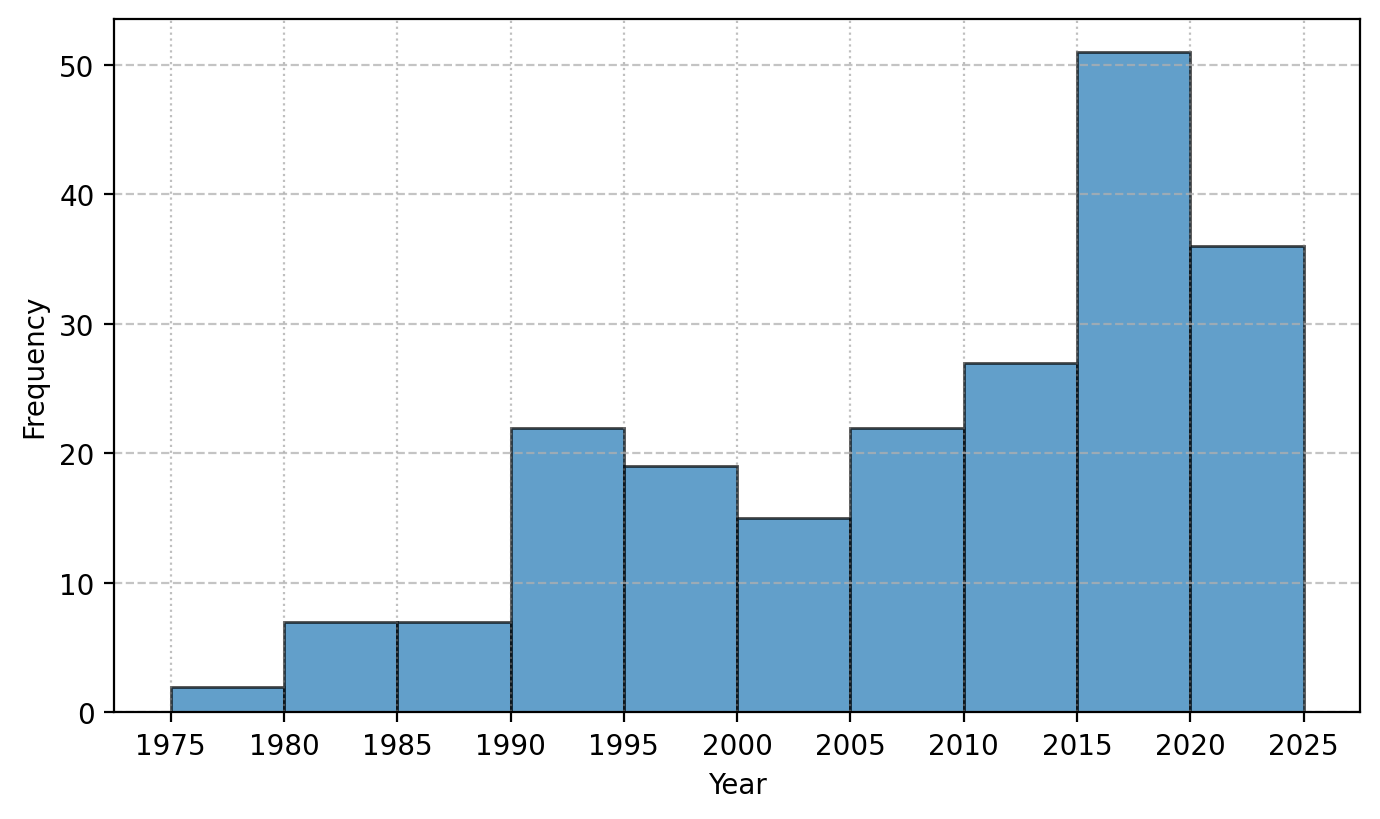

In [10]:
# Ensure the values are sorted for consistent bin calculation if desired,
# though plt.hist can handle unsorted data.
filtered_subset_values = sel_pub_year_df['year_n_pubs'].sort_values().values

# Define the desired bin size (10 years)
bin_size = 5

# Calculate the minimum and maximum values of the data
min_value = filtered_subset_values.min()
max_value = filtered_subset_values.max()

# Create an array of bin edges.
# The bins will start at a multiple of 10 equal to or less than min_value
# and go up to (and slightly beyond) a multiple of 10 equal to or greater than max_value.
# This ensures bins align with decades.
start_bin = (min_value // bin_size) * bin_size
end_bin = ((max_value // bin_size) + 1) * bin_size
bins = np.arange(start_bin, end_bin + bin_size, bin_size)


# Plot the histogram with the calculated bin edges
size=7
plt.figure(figsize=(size, .6*size)) # Adjust figure size for better readability
plt.hist(filtered_subset_values, bins=bins, edgecolor='black', alpha=0.7)

# Add labels and title for clarity
plt.xlabel("Year")
plt.ylabel("Frequency")
#plt.title(f"Histogram of Years with Bin Size of {bin_size}")

# Set x-axis ticks to display decades
# We can use the 'bins' array for xticks directly, or filter it for major decades
# For cleaner labels, we'll pick out the decade markers.
decade_ticks = np.arange(start_bin, end_bin + bin_size, bin_size)
plt.xticks(decade_ticks, rotation=0) # Rotate labels for better fit

# Enhance grid for better year readability
plt.grid(axis='y', alpha=0.75, linestyle='--')
plt.grid(axis='x', alpha=0.5, linestyle=':', color='gray')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()
plt.savefig('histogram_emergence.pdf', format="pdf", dpi=300)
# Display the plot
plt.show()

In [11]:
# select species based on the emergence

sel_pub_year_df = pub_year_df[pub_year_df['PublicationYear']>=1971]
sel_pub_year_df = sel_pub_year_df[sel_pub_year_df['n_years_to_n_pubs']<=10]
sel_pub_year_df = sel_pub_year_df[sel_pub_year_df['CanonicalSpecies'].isin(selected_species_list)]
selected_pub_species_list = sel_pub_year_df['CanonicalSpecies'].values
selected_data_df = data_df[data_df['CanonicalSpecies'].isin(selected_pub_species_list)]
print(f'#species {len(selected_pub_species_list)}')

#species 86


In [12]:
embedding_column = 'embedding'
embedding_column = 'onehot_embedding'
embedding_column = 'anonymised_embedding'

from draw_graph_linear_assignment import fast_visualisation
clustering_df  = fast_visualisation(
    selected_data_df, 
    counts_df,
    desired_attributes_for_embedding=None, 
    column_group_by='CanonicalSpecies', 
    column_embedding=embedding_column, 
    unique_classes=unique_classes,
    min_num_to_show=0,
    n_clusters=7,
    max_cluster_size=12,
    use_dendrogram_clustering=True,
    contamination=1e-6,
    filename='fig4_clusters.pdf',
    highlight_elements=None,
    figure_size=800)

In [13]:
total_n_species = 0
for cluster_id in sorted(set(clustering_df['cluster'].values)):
    df_grouped = clustering_df.groupby("cluster")["CanonicalSpecies"].agg(lambda x: ", ".join(x)).reset_index()
    species_in_cluster = df_grouped[df_grouped['cluster']==cluster_id]['CanonicalSpecies'].values.tolist()[0]
    cluster_size = len(species_in_cluster.split(","))
    total_n_species += cluster_size
    print(f'cluster id:{cluster_id}   #:{cluster_size}')
    print(species_in_cluster)
    print()
print(f'#species: {total_n_species}')

cluster id:0   #:4
Rickettsia africae, Rickettsia honei, Rickettsia japonica, Rickettsia massiliae

cluster id:1   #:8
Borrelia afzelii, Borrelia burgdorferi, Borrelia garinii, Borrelia mayonii, Borrelia miyamotoi, Borrelia spielmanii, Ehrlichia chaffeensis, Ehrlichia ewingii

cluster id:2   #:3
Helicobacter heilmannii, Helicobacter pylori, Sarcina ventriculi

cluster id:3   #:11
Bartonella henselae, Brachyspira pilosicoli, Capnocytophaga canimorsus, Chlamydia abortus, Chlamydia pneumoniae, Legionella bozemanae, Legionella longbeachae, Legionella micdadei, Legionella pneumophila, Leptospira borgpetersenii, Ureaplasma urealyticum

cluster id:4   #:10
Mycobacterium celatum, Mycobacterium colombiense, Mycobacterium genavense, Mycobacterium haemophilum, Mycobacterium lentiflavum, Mycobacterium malmoense, Mycobacterium sherrisii, Nocardia abscessus, Nocardia cyriacigeorgica, Nocardia nova

cluster id:5   #:11
Acinetobacter baumannii, Acinetobacter nosocomialis, Acinetobacter pittii, Aeromon

In [14]:
#add the cluster column to data_df
# Drop 'cluster' column if it already exists to avoid conflict
if 'cluster' in sel_pub_year_df.columns:
    sel_pub_year_df = sel_pub_year_df.drop(columns=['cluster'])

# Merge in new cluster labels
sel_pub_year_df = sel_pub_year_df.merge(clustering_df, on='CanonicalSpecies', how='right')

In [15]:
#add the cluster column to data_df
# Drop 'cluster' column if it already exists to avoid conflict
if 'cluster' in selected_data_df.columns:
    selected_data_df = selected_data_df.drop(columns=['cluster'])

# Merge in new cluster labels
selected_data_df = selected_data_df.merge(clustering_df, on='CanonicalSpecies', how='right')

In [16]:
from draw_graph_linear_assignment import plot_emergence_timeline
size=1000
fig1 = plot_emergence_timeline(
    sel_pub_year_df,
    
    # Show labels for the top-N species based on early publication count
    top_n=100,
    labels_from_clusters=None,
    
    # Scatterpoint jitter to reduce overlap
    x_jitter_amt=0.5,      # up to ±0.5 years of horizontal jitter
    y_jitter_amt=15,        # up to ±5 y-units of vertical jitter

    # Used to compute text width in years, e.g. 0.5 "years" per character
    year_per_char=0.5,

    # Padding between label lanes and central row
    padding=15,            # vertical space between the central band and label lanes
    lane_gap=5,           # vertical space between consecutive label lanes

    # Minimum row height for each cluster band (can grow if more lanes are needed)
    base_row_height=100,

    # Interval between year ticks on the x-axis
    dtick=5,

    # Random seed for reproducibility of jitter and lane placement
    random_state=2025,

    # Whether to separate rows by cluster (True = stacked bands, False = single band)
    separate_by_cluster=True,

    # Whether to color nodes by the "score" column instead of cluster color
    use_score=False,

    # Colormap for the score (reversed Yellow-Orange-Red)
    cmap='rdylbu_r',

    # Save the figure to this file (e.g., PDF for publication)
    filename='emergence_line_clusters.pdf',
    
    export_width=size,
    export_height=int(size*3),
)

In [17]:
from draw_graph_linear_assignment import plot_emergence_timeline
size=1000

desired_attributes_for_color_list = [["ZOONOSIS"]]

sel_pub_year_df = make_data_for_plot_emergence_timeline(sel_pub_year_df, selected_data_df, unique_classes, desired_attributes_for_color_list)


fig1 = plot_emergence_timeline(
    sel_pub_year_df,
    
    # Show labels for the top-N species based on early publication count
    top_n=13,
    labels_from_clusters=None,
    
    # Scatterpoint jitter to reduce overlap
    x_jitter_amt=0.5,      # up to ±0.5 years of horizontal jitter
    y_jitter_amt=30,        # up to ±5 y-units of vertical jitter

    # Used to compute text width in years, e.g. 0.5 "years" per character
    year_per_char=0.5,

    # Padding between label lanes and central row
    padding=150,            # vertical space between the central band and label lanes
    lane_gap=50,           # vertical space between consecutive label lanes

    # Minimum row height for each cluster band (can grow if more lanes are needed)
    base_row_height=100,

    # Interval between year ticks on the x-axis
    dtick=5,

    # Random seed for reproducibility of jitter and lane placement
    random_state=2025,

    # Whether to separate rows by cluster (True = stacked bands, False = single band)
    separate_by_cluster=False,

    # Whether to color nodes by the "score" column instead of cluster color
    use_score='score',

    # Colormap for the score (reversed Yellow-Orange-Red)
    cmap='rdylbu_r',

    # Save the figure to this file (e.g., PDF for publication)
    filename='emergence_line_ZOONOSIS.pdf',
    
    export_width=size,
    export_height=int(size*.5),
)
#sort labelas by score and only plot the top scoring ones 

In [18]:
from draw_graph_linear_assignment import plot_emergence_timeline
size=1000

desired_attributes_for_color_list = [["MULTIDRUG RESISTANCE"]]

sel_pub_year_df = make_data_for_plot_emergence_timeline(sel_pub_year_df, selected_data_df, unique_classes, desired_attributes_for_color_list)


fig1 = plot_emergence_timeline(
    sel_pub_year_df,
    
    # Show labels for the top-N species based on early publication count
    top_n=9,
    labels_from_clusters=None,
    
    # Scatterpoint jitter to reduce overlap
    x_jitter_amt=0.5,      # up to ±0.5 years of horizontal jitter
    y_jitter_amt=30,        # up to ±5 y-units of vertical jitter

    # Used to compute text width in years, e.g. 0.5 "years" per character
    year_per_char=0.5,

    # Padding between label lanes and central row
    padding=150,            # vertical space between the central band and label lanes
    lane_gap=50,           # vertical space between consecutive label lanes

    # Minimum row height for each cluster band (can grow if more lanes are needed)
    base_row_height=100,

    # Interval between year ticks on the x-axis
    dtick=5,

    # Random seed for reproducibility of jitter and lane placement
    random_state=2025,

    # Whether to separate rows by cluster (True = stacked bands, False = single band)
    separate_by_cluster=False,

    # Whether to color nodes by the "score" column instead of cluster color
    use_score='score',

    # Colormap for the score (reversed Yellow-Orange-Red)
    cmap='rdylbu_r',

    # Save the figure to this file (e.g., PDF for publication)
    filename='emergence_line_MULTIDRUG.pdf',
    
    export_width=size,
    export_height=int(size*.5),
)
#sort labelas by score and only plot the top scoring ones 

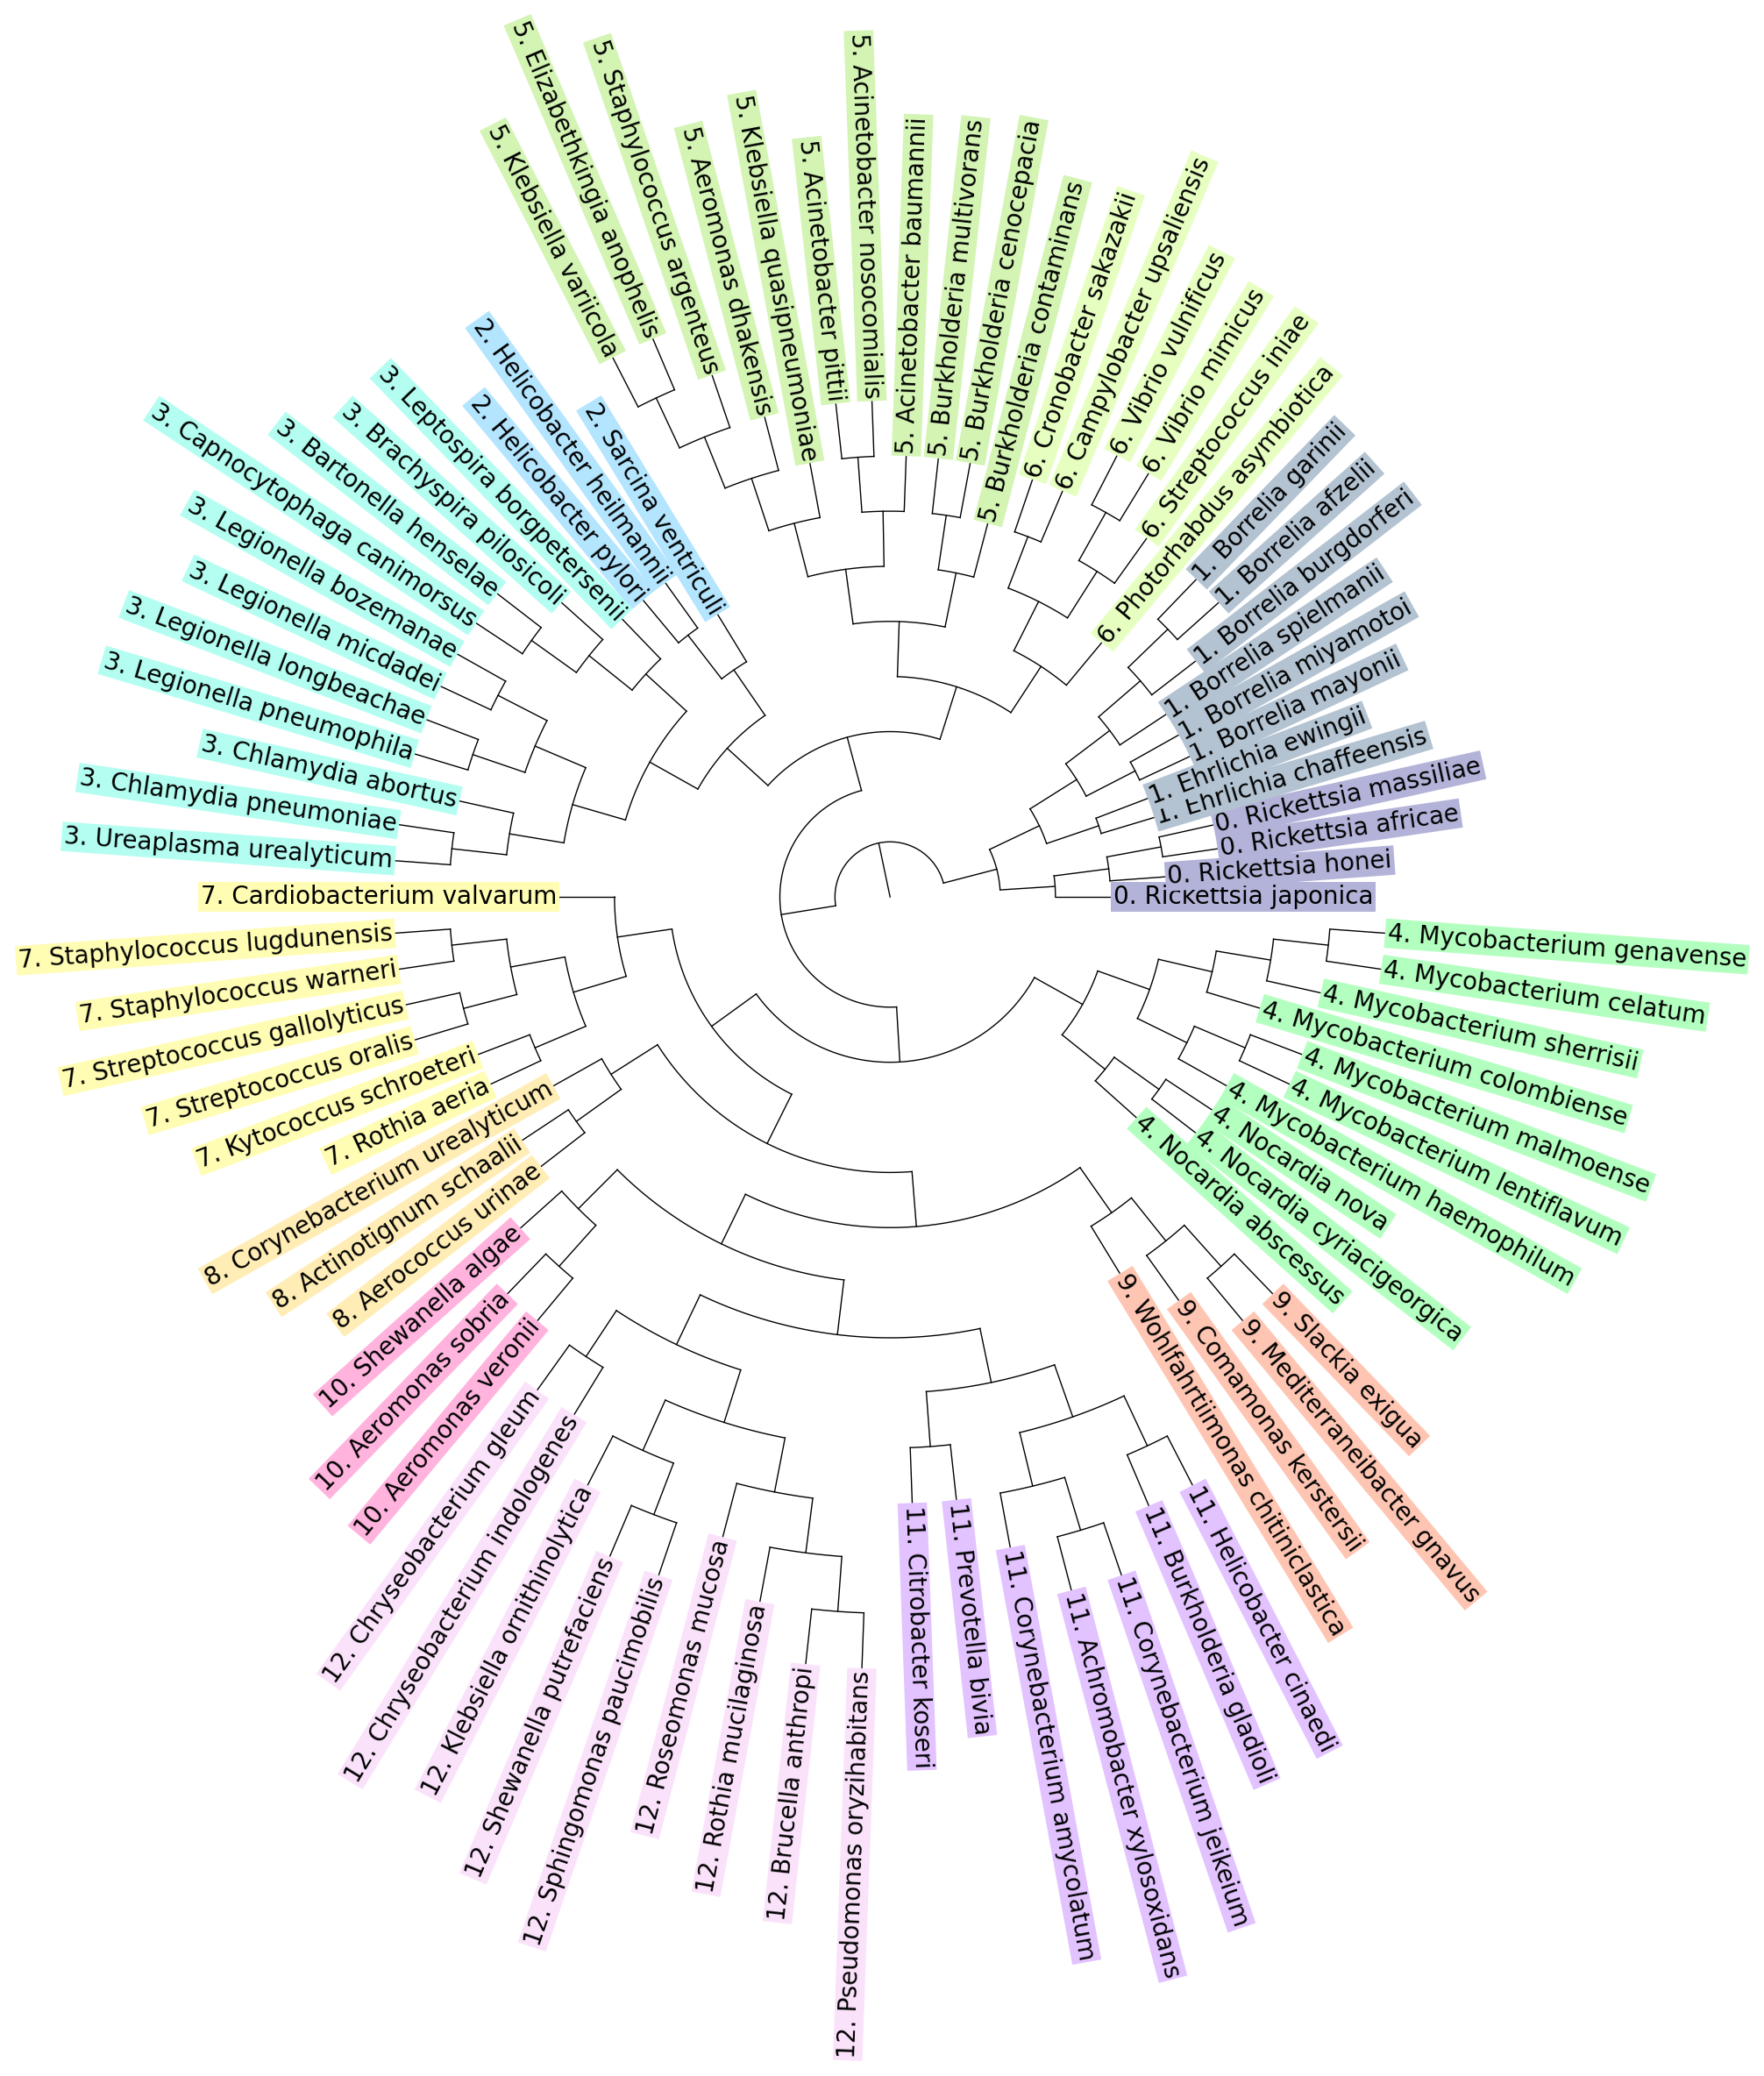

In [19]:
from draw_graph_linear_assignment import draw_dendrogram
for column_color_by in ['cluster']:
    draw_dendrogram(
        selected_data_df, 
        column_group_by='CanonicalSpecies', 
        column_embedding='anonymised_embedding', 
        column_color_by=column_color_by,
        min_num_to_show=3,
        white_fraction=.7,
        filename=f'{column_color_by}_den',
        use_legend=False,
        figsize=12)

---